In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/malav312/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/malav312/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Pre_Processing
def preprocess(text):
    stemmer = PorterStemmer()
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    stemmed = [stemmer.stem(item) for item in filtered]
    
    return ' '.join(stemmed)

In [5]:
df = pd.read_csv('news-train-1.csv')
df['Text'] = df['Text'].apply(preprocess)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed

# Transform the text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Function to evaluate decision tree with different criterion
def evaluate_decision_tree(criterion):
    clf = DecisionTreeClassifier(criterion=criterion, random_state=42)
    clf.fit(X_train_tfidf, y_train)
    
    # Training accuracy
    train_acc = clf.score(X_train_tfidf, y_train)
    
    # Validation accuracy
    val_acc = clf.score(X_val_tfidf, y_val)
    
    return train_acc, val_acc

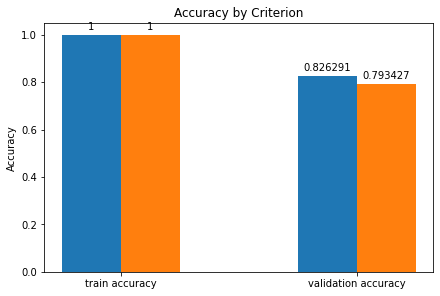

In [66]:
#Splitting the data
X = df['Text']
y = df['Category']
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['Category'], test_size=0.2, random_state=0)


criteria = ["gini", "entropy"]
train_accuracies = []
val_accuracies = []

width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout = 'constrained')
x = np.arange(2)
for criterion in criteria:
    train_acc, val_acc = evaluate_decision_tree(criterion)
    offset = width * multiplier
    rects = ax.bar(x + offset, [train_acc, val_acc], width, label=criterion)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Criterion')
ax.set_xticks(x + width / 2, ['train accuracy', 'validation accuracy'])
plt.show()

In [42]:
#5-corss validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold

vectorizer = CountVectorizer()
train_val_X = vectorizer.fit_transform(X)
val_X = vectorizer.transform(X_val)

print(train_val_X.shape)
print(val_X.shape)

(1063, 16919)
(213, 16919)


In [121]:
from sklearn import tree
import numpy as np
def dtc_parameter_tune(train_val_X, train_val_y,parameter, new =True):
    # depths = [2*i for i in range(5,16)] #min_sample_leaf
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in parameter:
        train_acc = []
        val_acc = []
        # print("========= depth:", depth)
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            if new==True: 
                dtc = tree.DecisionTreeClassifier(max_depth=parameter)
            else:
                dtc = tree.DecisionTreeClassifier(max_features=parameter)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return parameter, train_acc_all, val_acc_all


Inintially tried values wihth min_sample_leaf = [10,50,80,100,120,180,200] where the sample converged to 1. Hence taking values from [5,15](inclusive)

In [123]:
from tabulate import tabulate
depth_values = [2*i for i in range(5,16)]
depths, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X, y, parameter=depth_values, new=True)
results_table = []
for depth, train_acc, val_acc in zip(depths, train_acc_all, val_acc_all):
    results_table.append([depth, train_acc, val_acc])

# Print the table
headers = ["Minimum Sample Leaves", "Training Accuracy", "Validation Accuracy "]
print(tabulate(results_table, headers=headers, tablefmt="grid"))


TypeError: '<=' not supported between instances of 'list' and 'int'

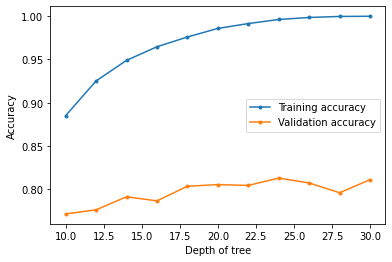

In [103]:
# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [110]:
#features for different criterion
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)
# X_tfidf = tfidf_vectorizer.transform(X)

#Sentiment
from textblob import TextBlob
df['sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['avg_word_length'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['max_word_length'] = df['Text'].apply(lambda x: np.max([len(word) for word in x.split()]))

count_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=1000)  # Adjust n-gram range and max_features
X_bigrams = count_vectorizer.fit_transform(df['Text'])



In [112]:
df

,ArticleId,Text,Category,sentiment,avg_word_length,max_word_length
0,893,ranger seal old firm win goal gregori vignal n...,sport,0.123455,5.470000,10
1,1164,bt program beat dialler scam bt introduc two i...,tech,0.037338,5.210526,12
2,1696,new yob target unveil fifti new area get speci...,politics,0.150054,5.153527,10
3,396,holm hit hamstr injuri kelli holm forc weekend...,sport,0.264286,5.152000,12
4,1862,capriati australian open jennif capriati becom...,sport,0.141209,6.054795,12
...,...,...,...,...,...,...
1058,101,housew lift channel 4 rate debut us televis hi...,entertainment,0.065152,5.195312,12
1059,1369,uk apolog coloni past day britain apologis col...,politics,-0.016718,5.324873,11
1060,2221,car pull us retail figur us retail sale fell 0...,business,0.349267,4.978610,11
1061,916,highburi tunnel player clear footbal associ sa...,sport,0.024709,5.178161,10


In [114]:
print(X_bigrams.shape)
print(X.shape)

(1063, 1000)
(1063,)


In [67]:
def evaluate_decision_tree_cv(parameter_name, parameter_values):
    results = {}
    
    for param_value in parameter_values:
        clf = DecisionTreeClassifier(random_state=42, **{parameter_name: param_value})
        print(clf)
        cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=5)
        results[param_value] = {
            'Training Accuracy': np.mean(cv_scores),
            'Validation Accuracy': clf.fit(X_train_tfidf, y_train).score(X_val_tfidf, y_val)
        }
    
    return results

# Evaluate decision tree with different min_samples_leaf values
min_samples_leaf_values = [10, 50, 100,150, 200]
results_min_samples_leaf = evaluate_decision_tree_cv('min_samples_leaf', min_samples_leaf_values)

# Print results in a table
print("min_samples_leaf\tTraining Accuracy\tValidation Accuracy")
for param_value, scores in results_min_samples_leaf.items():
    print(f"{param_value}\t\t{scores['Training Accuracy']:.3f}\t\t{scores['Validation Accuracy']:.3f}")




DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
DecisionTreeClassifier(min_samples_leaf=50, random_state=42)
DecisionTreeClassifier(min_samples_leaf=100, random_state=42)
DecisionTreeClassifier(min_samples_leaf=150, random_state=42)
DecisionTreeClassifier(min_samples_leaf=200, random_state=42)
min_samples_leaf	Training Accuracy	Validation Accuracy
10		0.768		0.784
50		0.659		0.714
100		0.461		0.587
150		0.411		0.498
200		0.364		0.371
